In [1]:
#import data manipulation packages 
import pandas as pd 
import numpy as np 
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt
import splitfolders

In [2]:
#import deep learning tools 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import metrics, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.utils import class_weight

2023-06-09 09:45:43.496912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 09:45:54.602622: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-06-09 09:46:14.433802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-09 09:46:17.331800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-09 09:46:17.332099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
def process_datasets():
    train_gen=tf.keras.utils.image_dataset_from_directory(directory='./output/train/',label_mode='categorical',color_mode='grayscale')
    valid_gen=tf.keras.utils.image_dataset_from_directory(directory='./output/val/',label_mode='categorical',color_mode='grayscale')
    test_gen=tf.keras.utils.image_dataset_from_directory(directory='./output/test/',label_mode='categorical',color_mode='grayscale')
    train_dataset=train_gen.map(
        lambda image,label: ((tf.cast(image,tf.float32),label))
    ).cache().map(
        lambda image,label:(tf.image.random_brightness(image,0.3),label)
    ).map(
        lambda image,label:(tf.image.random_contrast(image, lower=0.5, upper=1.0), label)
    ).shuffle(100).repeat(1)
    valid_gen=valid_gen.map(
        lambda image,label:((tf.cast(image,tf.float32)),label)
    ).cache()
    test_gen=test_gen.map(
        lambda image, label: (((tf.cast(image,tf.float32)),label))
    ).cache()
    return train_dataset,valid_gen,test_gen



In [5]:
train_set,valid,test=process_datasets()
print('train shape: ',train_set.element_spec)
for image, label in train_set.take(1):
    print("Image shape: ", image.shape)
    print("Label shape: ", label.shape)

Found 3839 files belonging to 4 classes.


2023-06-09 09:46:28.605214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-09 09:46:28.606274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-09 09:46:28.606687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 1279 files belonging to 4 classes.
Found 1282 files belonging to 4 classes.
train shape:  (TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))


2023-06-09 09:46:53.680955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3839]
	 [[{{node Placeholder/_4}}]]
2023-06-09 09:46:53.681503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3839]
	 [[{{node Placeholder/_4}}]]


Image shape:  (32, 256, 256, 1)
Label shape:  (32, 4)


2023-06-09 09:47:02.227016: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8,kernel_size=(3,3),activation = "relu" , input_shape = (256,256,1)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(32,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(16,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(8,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(4,activation ="softmax"),  #Adding the Output Layer
])
model.compile(loss='categorical_crossentropy',metrics=[metrics.CategoricalAccuracy(name='accuracy'),metrics.Precision(name='precision')],optimizer="adam")
model.summary()
#TODO 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 8)       80        
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 8)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 16)      1168      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 32)      

In [8]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)
init_weights=model.get_weights()
model.set_weights(init_weights)
model_hist=model.fit(
    train_set,verbose=2,
    epochs=50,
    validation_data=valid, 
    # callbacks=[earlystopping]
    )


Epoch 1/50


2023-06-09 09:47:27.063212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3839]
	 [[{{node Placeholder/_0}}]]
2023-06-09 09:47:27.063883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3839]
	 [[{{node Placeholder/_4}}]]
2023-06-09 09:47:49.620525: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-06-09 09:48:16.532456: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x1e3ab7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-0

120/120 - 75s - loss: 1.3259 - accuracy: 0.4066 - precision: 0.4561 - val_loss: 1.0998 - val_accuracy: 0.3495 - val_precision: 0.0000e+00 - 75s/epoch - 628ms/step
Epoch 2/50
120/120 - 16s - loss: 1.1342 - accuracy: 0.4751 - precision: 0.5644 - val_loss: 1.1259 - val_accuracy: 0.5004 - val_precision: 0.0000e+00 - 16s/epoch - 130ms/step
Epoch 3/50
120/120 - 16s - loss: 1.0864 - accuracy: 0.4928 - precision: 0.6075 - val_loss: 1.0404 - val_accuracy: 0.5004 - val_precision: 0.9028 - 16s/epoch - 134ms/step
Epoch 4/50
120/120 - 15s - loss: 1.0455 - accuracy: 0.4931 - precision: 0.6613 - val_loss: 0.9370 - val_accuracy: 0.5004 - val_precision: 0.7672 - 15s/epoch - 128ms/step
Epoch 5/50
120/120 - 15s - loss: 1.0181 - accuracy: 0.4957 - precision: 0.6749 - val_loss: 0.9625 - val_accuracy: 0.5004 - val_precision: 0.8193 - 15s/epoch - 124ms/step
Epoch 6/50
120/120 - 16s - loss: 0.9877 - accuracy: 0.4863 - precision: 0.7091 - val_loss: 0.9331 - val_accuracy: 0.5872 - val_precision: 0.8254 - 16s/ep

2023-06-09 09:59:16.420305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 86 of 100
2023-06-09 09:59:22.238143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


120/120 - 34s - loss: 0.4026 - accuracy: 0.8070 - precision: 0.8753 - val_loss: 0.5206 - val_accuracy: 0.7576 - val_precision: 0.8476 - 34s/epoch - 280ms/step
Epoch 40/50
120/120 - 16s - loss: 0.4033 - accuracy: 0.8044 - precision: 0.9315 - val_loss: 0.6855 - val_accuracy: 0.7568 - val_precision: 0.8539 - 16s/epoch - 136ms/step
Epoch 41/50
120/120 - 15s - loss: 0.4352 - accuracy: 0.7885 - precision: 0.9144 - val_loss: 0.6162 - val_accuracy: 0.7615 - val_precision: 0.8670 - 15s/epoch - 125ms/step
Epoch 42/50
120/120 - 15s - loss: 0.3966 - accuracy: 0.8059 - precision: 0.9330 - val_loss: 0.5169 - val_accuracy: 0.7678 - val_precision: 0.8686 - 15s/epoch - 128ms/step
Epoch 43/50
120/120 - 15s - loss: 0.3880 - accuracy: 0.8052 - precision: 0.9339 - val_loss: 0.5262 - val_accuracy: 0.7756 - val_precision: 0.8792 - 15s/epoch - 124ms/step
Epoch 44/50
120/120 - 14s - loss: 0.3356 - accuracy: 0.8242 - precision: 0.9637 - val_loss: 0.5249 - val_accuracy: 0.7803 - val_precision: 0.8770 - 14s/epoch

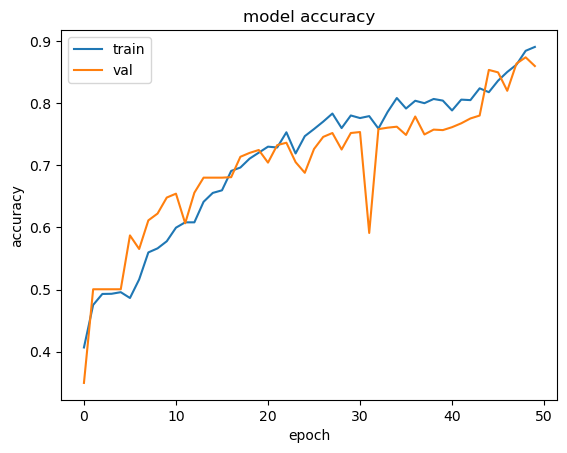

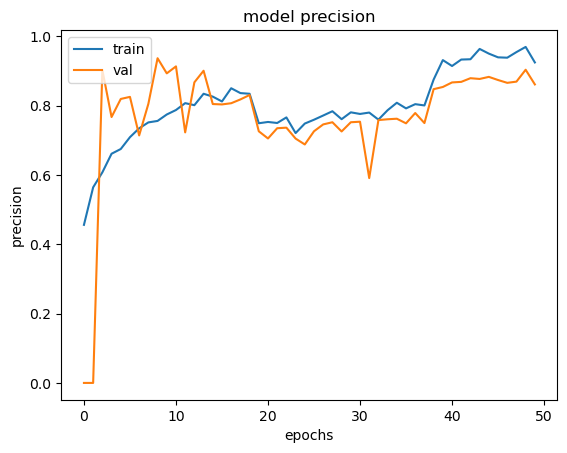

In [9]:
# function to plot accuracy 


history=model_hist.history
acc=history['accuracy']
val_acc = history['val_accuracy']
precision = history['precision']
val_precision= history['val_precision']
loss=history['loss']
val_loss=history['val_loss']
epochs=model_hist.epoch

plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

plt.plot(precision)
plt.plot(val_precision)
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epochs')
plt.legend(['train',"val"],loc='upper left')
plt.show()



In [19]:
test_loss,test_acc,test_precision=model.evaluate(test)
print(model.metrics_names)

41/41 [==============================] - 2s 36ms/step - loss: 0.5750 - accuracy: 0.8658 - precision: 0.8692
['loss', 'accuracy', 'precision']
